In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel("Estimate_power2.xlsx")
data.head()

,hour,unit_no,fuel_type,temp,moisture,power,mvar
0,1,1,A,3,94,250,22
1,2,1,A,3,96,250,23
2,3,1,A,2,95,250,23
3,4,1,A,2,95,251,25
4,5,1,A,2,95,252,26


In [3]:
data=data[data["power"]>150]
data.shape

(921, 7)

In [4]:
# Change object to integer:
data["fuel_type"][data["fuel_type"]=="A"] = 1; 
data["fuel_type"][data["fuel_type"]=="B"] = 2;
data["fuel_type"][data["fuel_type"]=="C"] = 3;

In [5]:
data['fuel_type'].value_counts()

1    663
Name: fuel_type, dtype: int64

In [6]:
data["fuel_type"].fillna(method='bfill', inplace=True)

In [7]:
data.isnull().sum()

hour         0
unit_no      0
fuel_type    0
temp         0
moisture     0
power        0
mvar         0
dtype: int64

In [8]:
X = data[["moisture","unit_no","temp","fuel_type","power"]]
y = data[["mvar"]]
y

,mvar
0,22
1,23
2,23
3,25
4,26
...,...
994,15
995,15
996,14
997,16


In [9]:
X

,moisture,unit_no,temp,fuel_type,power
0,94,1,3,1,250
1,96,1,3,1,250
2,95,1,2,1,250
3,95,1,2,1,251
4,95,1,2,1,252
...,...,...,...,...,...
994,6,6,15,1,224
995,8,6,16,1,240
996,21,6,18,1,238
997,11,6,19,1,236


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [12]:
# Define Ridge Regression model with alpha=0.5 (regularization strength)
ridge_model = Ridge(alpha=0.5)

In [13]:
# Fit the model to the training data 
ridge_model.fit(X_train_scaled, y_train)

Ridge(alpha=0.5)

In [14]:
# Make predictions on the testing data 
y_pred = ridge_model.predict(X_test_scaled)

In [15]:
# Calculate Mean Squared Error (MSE) of the predictions 
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 164.4152337934614
R-squared: -0.25523400609524405


# Tuning hyperparameters

In [16]:
# Define the Ridge model
ridge_model = Ridge()

# Define the hyperparameters to tune
param_grid = {'solver': ['auto','svd','cholesky','lsqr','sparse_cg','sag','saga','lbfgs'],
              'alpha': [0.001,0.01,0.1, 1, 10,100,1000]}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(ridge_model, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'alpha': 1, 'solver': 'sag'}
Best score: 0.4614121776107557


# Testing Tuned hyperparameters

In [18]:
# Define Ridge Regression model with hyperparameters
ridge_model = Ridge(alpha=1, solver='sag')

In [19]:
# Fit the model to the training data 
ridge_model.fit(X_train_scaled, y_train)

Ridge(alpha=1, solver='sag')

In [20]:
# Make predictions on the testing data 
y_pred = ridge_model.predict(X_test_scaled)

# Evaluation

In [21]:
# Calculate Mean Squared Error (MSE) of the predictions 
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 164.36998560422083
R-squared: -0.2564895727806109


# Trying dimention reduction for this model

In [22]:
# Apply PCA to reduce the number of features to 3
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)

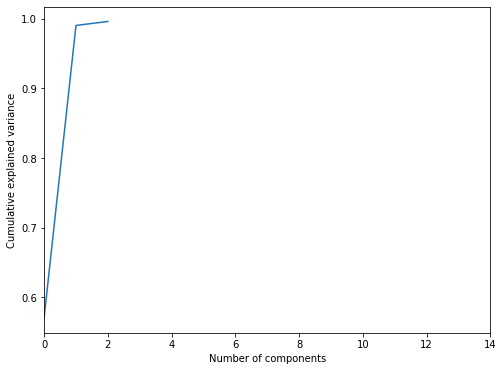

In [23]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

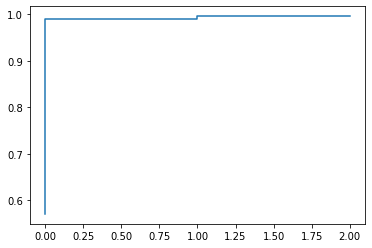

In [24]:
cumulative=np.cumsum(pca.explained_variance_ratio_)
plt.step([i for i in range(len(cumulative))],cumulative)
plt.show()

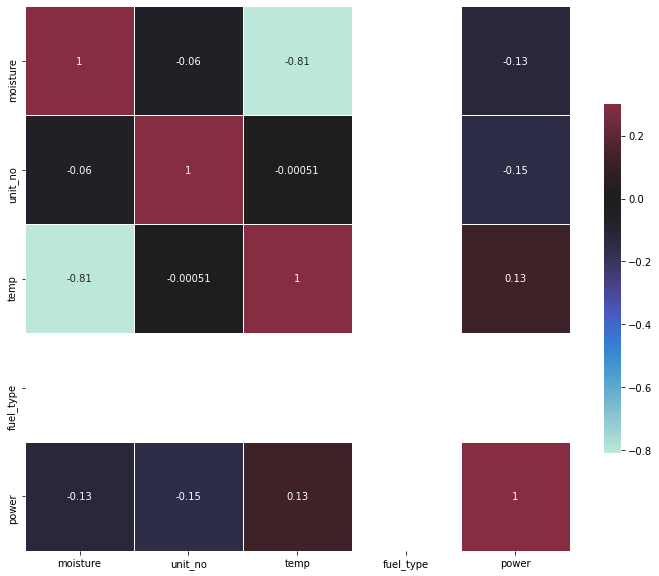

In [25]:
plt.figure(figsize=(10,10))
sns.heatmap(X_train.corr(),vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.tight_layout()
plt.show()

In [26]:
pca=PCA().fit(X_train)
print(pca.explained_variance_ratio_)
print()
print(X_train.columns.values.tolist())

[5.70536159e-01 4.19515641e-01 5.75168589e-03 4.19651473e-03
 3.31125627e-38]

['moisture', 'unit_no', 'temp', 'fuel_type', 'power']


In [27]:
pipeline=Pipeline(steps=[('pca', PCA(n_components=3)), ('ridge', Ridge(alpha=100, solver='lsqr'))])

In [28]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=3)),
                ('ridge', Ridge(alpha=100, solver='lsqr'))])

In [29]:
y_pred = pipeline.predict(X_test)

In [30]:
# Calculate Mean Squared Error (MSE) of the predictions 
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 187.808303847901
R-squared: -0.9726508085158663
